<a href="https://colab.research.google.com/github/yaremenko8/heartbeats_cnn/blob/main/heartbeats%20cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports, procedures and data preparation

In [1]:
import os
os.environ['PYTHONHASHSEED'] = str(0)

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras import layers

import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

def reset_random_seeds():
  os.environ['PYTHONHASHSEED'] = str(0)
  np.random.seed(2)
  tf.random.set_seed(2)
  random.seed(2)

In [3]:
def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel('train')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

from sklearn.metrics import balanced_accuracy_score, accuracy_score
    
def show_confusion_matrix(confusion_matrix):
    print('\n' + str(confusion_matrix))
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.values.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)

    print('acc  = ' + str(round(ACC[0]*100.0,2)) + '% , ' + \
          str(round(ACC[1]*100.0,2)) + '% , ' + \
          str(round(ACC[2]*100.0,2)) + '% , ' + \
          str(round(ACC[3]*100.0,2)) + '% , ' + \
          str(round(ACC[4]*100.0,2)) + '% ')
    print('ppv  = ' + str(round(PPV[0]*100.0,2)) + '% , ' + \
          str(round(PPV[1]*100.0,2)) + '% , ' + \
          str(round(PPV[2]*100.0,2)) + '% , ' + \
          str(round(PPV[3]*100.0,2)) + '% , ' + \
          str(round(PPV[4]*100.0,2)) + '% ')
    print('sen  = ' + str(round(TPR[0]*100.0,2)) + '% , ' + \
          str(round(TPR[1]*100.0,2)) + '% , ' + \
          str(round(TPR[2]*100.0,2)) + '% , ' + \
          str(round(TPR[3]*100.0,2)) + '% , ' + \
          str(round(TPR[4]*100.0,2)) + '% ')
    print('spec = ' + str(round(TNR[0]*100.0,2)) + '% , ' + \
          str(round(TNR[1]*100.0,2)) + '% , ' + \
          str(round(TNR[2]*100.0,2)) + '% , ' + \
          str(round(TNR[3]*100.0,2)) + '% , ' + \
          str(round(TNR[4]*100.0,2)) + '% ')

In [4]:
# MIT-BIH Arrhythmia Database
# https://physionet.org/content/mitdb/1.0.0/
mitdbs = [100,101,102,103,104,105,106,107,108,109,111,112,113,114,115,116,117,118,119,121,122,123,124,200,201,202,203,205,207,208,209,210,212,213,214,215,217,219,220,221,222,223,228,230,231,232,233,234]

In [5]:
reset_random_seeds()

X_list = list() 
y_list = list()
for db in mitdbs:
    if os.path.isfile('./beats/'+ str(db) + '.npy') : 
        db_dict = np.load('./beats/'+ str(db) + '.npy', allow_pickle=True).item()
        beats   = db_dict['beats']
    
        for beat in beats :
            # X is ECG signal
            X_list.append(beat[1][::3])
            # y is categorie
            y_list.append(beat[0])
    else :
        print('./beats/'+ str(db) + '.npy' + ' file does not exist')

    
X = np.array(X_list)
y = np.array(y_list)
X = (X - np.min(X)) / (np.max(X) - np.min(X))
print(X.shape)

./beats/102.npy file does not exist
./beats/104.npy file does not exist
(103421, 87)


In [6]:
print('Type N number of beats = ' + str(len(np.where(y==0)[0])))
print('Type S number of beats = ' + str(len(np.where(y==1)[0])))
print('Type V number of beats = ' + str(len(np.where(y==2)[0])))
print('Type F number of beats = ' + str(len(np.where(y==3)[0])))
print('Type Q number of beats = ' + str(len(np.where(y==4)[0])))
print('Total  number of beats = ' + str(len(y)))

Type N number of beats = 90078
Type S number of beats = 2704
Type V number of beats = 6271
Type F number of beats = 786
Type Q number of beats = 3582
Total  number of beats = 103421


In [7]:
weight0 = 1.0 - (len(np.where(y==0)[0]) / len(y))
weight1 = 1.0 - (len(np.where(y==1)[0]) / len(y))
weight2 = 1.0 - (len(np.where(y==2)[0]) / len(y))
weight3 = 1.0 - (len(np.where(y==3)[0]) / len(y))
weight4 = 1.0 - (len(np.where(y==4)[0]) / len(y))
class_weight = {0: weight0 , 1: weight1 , 2: weight2 ,3 : weight3 , 4 : weight4}
weights = [weight0 , weight1 , weight2 , weight3 , weight4]
print(class_weight)

{0: 0.12901635064445327, 1: 0.9738544396205799, 2: 0.9393643457324915, 3: 0.9923999961323136, 4: 0.9653648678701617}


# Feature engineering approach

### Attempt 0: Naive baseline
The most obvious feature set is simply the downsampled signal. This rather simplistic approach may not achieve good results, though it can certainly be used as an informative benchmark to compare against.

In [8]:
# Feature computations
X_ = X[:, ::6].copy()

#### Results
Despite its embarassing simplicity, this feature-set yields an average recall of 73.4%, which is not too bad.

In [9]:
# CrossVal
reset_random_seeds()
model = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced',
                               random_state=0, n_jobs=6)
results = cross_validate(model, X=X_, y=y, scoring=['accuracy', 'balanced_accuracy'], cv=5)
print("Mean balanced accuracy: ", np.mean(results['test_balanced_accuracy']))
print("Mean accuracy: ", np.mean(results['test_accuracy']))


Mean balanced accuracy:  0.7355814397960482
Mean accuracy:  0.9183046196675113


### Attempt 1: Extrema and their locations
The first approach that we tried in our endevour for decent accuracy in the absence of deep learning is using the data about extrema to predict disorders. On the surface it does seem like a decent approach, since such important metrics as QT interval, heart rate, blood pressure and most important parameters that regard each of the PQRS intervals are all determined by minima, maxima and their locations.

In [10]:
# Feature computations
from scipy.signal import find_peaks

def ordered_extrema(x, num_maxima=3, num_minima=3):
    maxima = find_peaks(x)[0]
    total_maxima = maxima.size
    maxima = maxima[:num_maxima]
    maxima = np.argsort(-x[maxima])
    maxima_values = x[maxima]
    missing_maxima = num_maxima - maxima.size
    maxima = np.concatenate((maxima, -np.ones(missing_maxima)))
    maxima_values = np.concatenate((maxima_values, -np.ones(missing_maxima)))
    
    minima = find_peaks(-x)[0]
    total_minima = minima.size
    minima = minima[:num_minima]
    minima = np.argsort(x[minima])
    minima_values = x[minima]
    missing_minima = num_minima - minima.size
    minima = np.concatenate((minima, -np.ones(missing_minima)))
    minima_values = np.concatenate((minima_values, -np.ones(missing_minima)))
    
    return np.concatenate((maxima, 
                           maxima_values, 
                           minima, 
                           minima_values,
                           [total_maxima + total_minima],
                           x[::6]))


X_ = np.apply_along_axis(ordered_extrema, 1, X)

#### Results
Despite the promising intuition behind the approach, in practice the model failed to improve the baseline.

In [11]:
# CrossVal
reset_random_seeds()
model = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced',
                               random_state=0, n_jobs=6)
results = cross_validate(model, X=X_, y=y, scoring=['accuracy', 'balanced_accuracy'], cv=5)
print("Mean balanced accuracy: ", np.mean(results['test_balanced_accuracy']))
print("Mean accuracy: ", np.mean(results['test_accuracy']))


Mean balanced accuracy:  0.7312509327211005
Mean accuracy:  0.9170572633016347


It can be inferred from importance ratings that the newly introduced features bear little to no significance in comparison to the naive feature set.

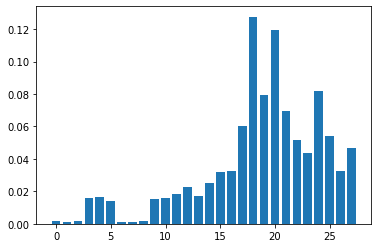

In [12]:
# Importance
model.fit(X_, y)
plt.bar(range(X_.shape[1]), model.feature_importances_)
plt.show()

### Attempt 2: Spectral characteristics
Another natural insight comes from the perspective of signal processing. It makes sense to assume that presence or absence of certain frequencies can tell a lot about the anomalies of one's heartbeat, therefore spectral density can serve as a useful source of diagnostic criteria.

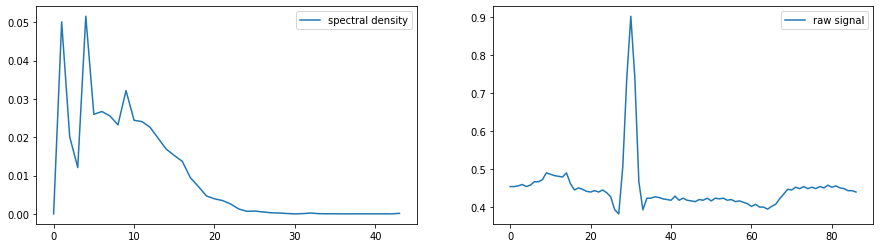

In [13]:
from scipy.signal import periodogram

fig, axes = plt.subplots(1, 2)
fig.set_figwidth(15)
axes[0].plot(periodogram(X[0])[1], label="spectral density")
axes[0].legend()
axes[1].plot(X[0], label="raw signal")
axes[1].legend()
plt.show()

In [14]:
# Feature computations
def spectral_characteristics(x):
    return np.concatenate((periodogram(x)[1][:25] * 10, x[::6]))


X_ = np.apply_along_axis(spectral_characteristics, 1, X)

#### Results
Finally, an approach of ours succeeds at slightly improving the baseline. A humble improvement of 3% was achieved by introducing a part of the spectrum into the initial feature-set, granting an 11% reduction in mean error frequency. There were further trials of several new tweaks and feature ideas, but none of them were by a significant ammount superior to the approach in question.

In [15]:
# CrossVal
reset_random_seeds()
model = RandomForestClassifier(n_estimators=100, max_depth=None, class_weight='balanced',
                               random_state=0, n_jobs=6)
results = cross_validate(model, X=X_, y=y, scoring=['accuracy', 'balanced_accuracy'], cv=5)
print("Mean balanced accuracy: ", np.mean(results['test_balanced_accuracy']))
print("Mean accuracy: ", np.mean(results['test_accuracy']))


Mean balanced accuracy:  0.7631221269281674
Mean accuracy:  0.9229940875806191


It can be observed from the feature ratings that certain densities of certain frequencies bear great diagnostic value and prety much all newly introduced features seem to be at the very least no less important then the naive features.

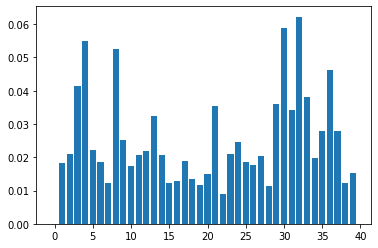

In [16]:
# Importance
model.fit(X_, y)
plt.bar(range(X_.shape[1]), model.feature_importances_)
plt.show()

# DL approach
The potential application of deep learning, specifically convolutional neural networks, to this problem bears great promise due to the capability of CNNs to construct topology-aware features. Diagnosis via ECG readings is ALL ABOUT topology-aware features: spikes, drops, vibrations, plateaus, periodicity and so on. Some of those features can indeed be constructed manually by a quallified physician, however even the latter will not nescessarily be able to get the kind of insights that a CNN is capable of discovering automatically.

In [17]:
reset_random_seeds()
# Data preparation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

num_classes = 5

y_Train=tf.keras.utils.to_categorical(y_train,num_classes)
y_Train=y_Train.reshape(len(y_Train),num_classes)

y_Test=tf.keras.utils.to_categorical(y_test,num_classes)
y_Test=y_Test.reshape(len(y_Test),num_classes)

A reduced and tweaked version of the CNN described in [this paper](https://www.sciencedirect.com/science/article/pii/S0010482517302810?via%3Dihu).

In [18]:
reset_random_seeds()

inputs  = layers.Input(shape=(87,))
reshape = layers.Reshape((87,1))(inputs)
conv1   = layers.Conv1D(5,  3, activation='linear')(reshape)
conv1   = layers.ReLU()(conv1)
conv1   = layers.MaxPooling1D(2,2)(conv1)
conv2   = layers.Conv1D(10, 4, activation='linear')(conv1)
conv2   = layers.ReLU()(conv2)
conv2   = layers.MaxPooling1D(2,2)(conv2)
conv3   = layers.Conv1D(20, 4, activation='linear')(conv2)
conv3   = layers.ReLU()(conv3)
conv3   = layers.MaxPooling1D(2,2)(conv3)
flat    = layers.Flatten()(conv3)
dense1  = layers.Dense(15, activation='linear')(flat)
dense1  = layers.ReLU()(dense1)
dense2  = layers.Dense(12, activation='linear')(dense1)
dense2  = layers.ReLU()(dense2)
dense3  = layers.Dense(5, activation='softmax')(dense2)
model   = tf.keras.Model(inputs=inputs, outputs=dense3)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 87)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 87, 1)             0         
_________________________________________________________________
conv1d (Conv1D)              (None, 85, 5)             20        
_________________________________________________________________
re_lu (ReLU)                 (None, 85, 5)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 42, 5)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 39, 10)            210       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 39, 10)            0     

In [19]:
reset_random_seeds()
model.compile(tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
earlyStopping=tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                               patience=3)
train_history = model.fit(X_train, y_Train, batch_size=32, epochs=25, validation_split=0.3, callbacks=[earlyStopping],class_weight = class_weight)

Epoch 1/25
2037/2037 [==============================] - 12s 5ms/step - loss: 0.2260 - categorical_accuracy: 0.8677 - val_loss: 0.3509 - val_categorical_accuracy: 0.8949
Epoch 2/25
2037/2037 [==============================] - 10s 5ms/step - loss: 0.1115 - categorical_accuracy: 0.8849 - val_loss: 0.3088 - val_categorical_accuracy: 0.9207
Epoch 3/25
2037/2037 [==============================] - 10s 5ms/step - loss: 0.0921 - categorical_accuracy: 0.9201 - val_loss: 0.2777 - val_categorical_accuracy: 0.9152
Epoch 4/25
2037/2037 [==============================] - 10s 5ms/step - loss: 0.0761 - categorical_accuracy: 0.9371 - val_loss: 0.2194 - val_categorical_accuracy: 0.9483
Epoch 5/25
2037/2037 [==============================] - 10s 5ms/step - loss: 0.0652 - categorical_accuracy: 0.9510 - val_loss: 0.1729 - val_categorical_accuracy: 0.9589
Epoch 6/25
2037/2037 [==============================] - 10s 5ms/step - loss: 0.0583 - categorical_accuracy: 0.9527 - val_loss: 0.1373 - val_categorical_acc

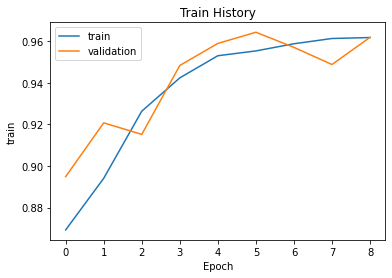

In [20]:
show_train_history(train_history, 'categorical_accuracy', 'val_categorical_accuracy')

#### Results
Lo and behold, the produced model has a mean recall (balanced accuracy) of a whopping 89%! The DL approach yields an error rate that is less than **HALF** as large as the one yielded by feature engineering.

In [21]:
prediction = model.predict(X_test,batch_size=32)
prediction = prediction.argmax(axis=-1)
print("Accuracy: ", accuracy_score(y_test, prediction))
print("Balanced accuracy: ", balanced_accuracy_score(y_test, prediction))

Accuracy:  0.9649037996712753
Balanced accuracy:  0.8875451839227304


In [22]:
print("CONFUSION MATRIX:")
confusion_matrix = pd.crosstab(y_test, prediction, rownames=['label'], colnames=['predict'])
show_confusion_matrix(confusion_matrix)

CONFUSION MATRIX:

predict     0    1    2   3    4
label                           
0        8854  151   54  51    0
1          40  178    0   0    0
2          26    8  542   8    0
3          21    0    3  63    0
4           0    0    1   0  343
acc  = 96.68% , 98.08% , 99.03% , 99.2% , 99.99% 
ppv  = 99.03% , 52.82% , 90.33% , 51.64% , 100.0% 
sen  = 97.19% , 81.65% , 92.81% , 72.41% , 99.71% 
spec = 92.94% , 98.43% , 99.41% , 99.42% , 100.0% 


pretty good, right?
# NOW LET'S SEE IF WE CAN MAKE IT EVEN BETTER


We tried to add a LSTM layer to the architecture. Based on the result obtained, our best choice is the LSTM layer with 5 units and 0.2 recurrent drop out.

In [23]:
reset_random_seeds()

inputs  = layers.Input(shape=(87,))
reshape = layers.Reshape((87,1))(inputs)

conv1   = layers.Conv1D(5,  3, activation='linear')(reshape)
conv1   = layers.ReLU()(conv1)
conv1   = layers.MaxPooling1D(2,2)(conv1)
conv2   = layers.Conv1D(10, 4, activation='linear')(conv1)
conv2   = layers.ReLU()(conv2)
conv2   = layers.MaxPooling1D(2,2)(conv2)
conv3   = layers.Conv1D(20, 4, activation='linear')(conv2)
conv3   = layers.ReLU()(conv3)
conv3   = layers.MaxPooling1D(2,2)(conv3)
flat    = layers.Flatten()(conv3)
cnn_dense = layers.Dense(15, activation='linear')(flat)
cnn_dense = layers.ReLU()(cnn_dense)

lstm1 = layers.LSTM(5,recurrent_dropout=0.2)(reshape)
lstm_dense = layers.Dense(5, activation='linear')(lstm1)
lstm_dense = layers.ReLU()(lstm_dense)

concat = layers.Concatenate(axis=-1)([cnn_dense, lstm_dense])
dense2  = layers.Dense(15, activation='linear')(concat)
dense2  = layers.ReLU()(dense2)
dense3  = layers.Dense(5, activation='softmax')(dense2)
model   = tf.keras.Model(inputs=inputs, outputs=dense3)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 87)]         0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 87, 1)        0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 85, 5)        20          reshape_1[0][0]                  
__________________________________________________________________________________________________
re_lu_5 (ReLU)                  (None, 85, 5)        0           conv1d_3[0][0]                   
____________________________________________________________________________________________

In [24]:
model.compile(tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])
earlyStopping=tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                               patience=6, restore_best_weights=True)
train_history = model.fit(X_train, y_Train, batch_size=128, epochs=40, validation_split=0.3, callbacks=[earlyStopping],class_weight = class_weight)

Epoch 1/40
510/510 [==============================] - 36s 66ms/step - loss: 0.2894 - categorical_accuracy: 0.8084 - val_loss: 0.3816 - val_categorical_accuracy: 0.9029
Epoch 2/40
510/510 [==============================] - 36s 71ms/step - loss: 0.1454 - categorical_accuracy: 0.8829 - val_loss: 0.3649 - val_categorical_accuracy: 0.8903
Epoch 3/40
510/510 [==============================] - 36s 71ms/step - loss: 0.1251 - categorical_accuracy: 0.8888 - val_loss: 0.3269 - val_categorical_accuracy: 0.9216
Epoch 4/40
510/510 [==============================] - 36s 72ms/step - loss: 0.1099 - categorical_accuracy: 0.9073 - val_loss: 0.3111 - val_categorical_accuracy: 0.9209
Epoch 5/40
510/510 [==============================] - 36s 71ms/step - loss: 0.1011 - categorical_accuracy: 0.9220 - val_loss: 0.2806 - val_categorical_accuracy: 0.9285
Epoch 6/40
510/510 [==============================] - 36s 71ms/step - loss: 0.0951 - categorical_accuracy: 0.9274 - val_loss: 0.2128 - val_categorical_accuracy:

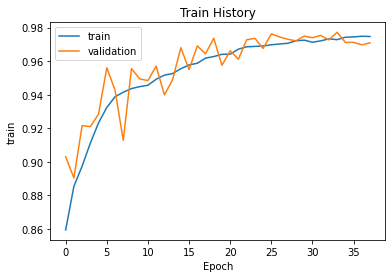

In [25]:
show_train_history(train_history, 'categorical_accuracy', 'val_categorical_accuracy')

#### Results
The introduction of LSTM-CNN hybrid architecture imporoved the balanced accuracy all the way to 92%, reducing the average misclassification frequency by 23% in comparison to the non-hybrid architecture. A remarkable boost in performance!

In [26]:
prediction = model.predict(X_test,batch_size=32)
prediction = prediction.argmax(axis=-1)
print("Accuracy: ", accuracy_score(y_test, prediction))
print("Balanced accuracy: ", balanced_accuracy_score(y_test, prediction))

Accuracy:  0.9774726868413419
Balanced accuracy:  0.9152531820570466


In [27]:
print("CONFUSION MATRIX:")
confusion_matrix = pd.crosstab(y_test, prediction, rownames=['label'], colnames=['predict'])
show_confusion_matrix(confusion_matrix)

CONFUSION MATRIX:

predict     0    1    2   3    4
label                           
0        8951  106   36  16    1
1          36  182    0   0    0
2          15    1  564   4    0
3          16    0    2  69    0
4           0    0    0   0  344
acc  = 97.81% , 98.62% , 99.44% , 99.63% , 99.99% 
ppv  = 99.26% , 62.98% , 93.69% , 77.53% , 99.71% 
sen  = 98.25% , 83.49% , 96.58% , 79.31% , 100.0% 
spec = 94.57% , 98.94% , 99.61% , 99.8% , 99.99% 
